In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
# file_path = '/content/drive/MyDrive/nlp-exercises/ecommerce_synthetic_dataset.csv'
file_path = 'exercise_1_sentiment.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')

In [7]:
# Display the first few rows of the data
from IPython.display import display
# Display the first few rows of the data
print("First 5 rows of the dataset:")
display(data.head())

First 5 rows of the dataset:


,UserID,UserName,Age,Gender,Country,SignUpDate,ProductID,ProductName,Category,Price,...,Quantity,TotalAmount,HasDiscountApplied,DiscountRate,ReviewScore,ReviewText,LastLogin,SessionDuration,DeviceType,ReferralSource
0,1,User_1,39,Male,UK,2021-02-01,8190,Shoes,Books,532.37,...,1,532.37,False,0.02,5.1,Excellent,2024-05-03 04:04:27.591583,45.02,Mobile,Social Media
1,2,User_2,25,Female,Canada,2020-12-04,9527,T-shirt,Accessories,848.83,...,1,848.83,True,0.29,5.1,Excellent,2024-08-31 04:04:27.591606,13.83,Mobile,Social Media
2,3,User_3,43,Male,Canada,2022-07-08,3299,Headphones,Apparel,64.88,...,2,129.76,False,0.03,3.2,Good,2024-07-28 04:04:27.591611,59.09,Tablet,Organic Search
3,4,User_4,44,Male,Germany,2021-06-07,8795,T-shirt,Apparel,465.08,...,2,930.16,False,0.23,4.3,Good,2024-03-11 04:04:27.591615,55.42,Desktop,Email Marketing
4,5,User_5,23,Female,Canada,2021-11-06,1389,Shoes,Books,331.82,...,1,331.82,False,0.02,5.1,Average,2024-07-02 04:04:27.591619,14.99,Tablet,Email Marketing


# Let us under the Dataset

| Column(s)                  | Description                                                               | Analysis                                                                                     |
|----------------------------|---------------------------------------------------------------------------|----------------------------------------------------------------------------------------------|
| **UserID, UserName**       | Unique identifiers for each user.                                         | Not valuable for analysis unless focusing on user-level data.                               |
| **Age, Gender, Country**   | Demographic attributes of users.                                          | Useful for segmentation and demographic analysis.                                            |
| **SignUpDate**             | The date when the user signed up.                                         | Could be used for customer lifecycle or loyalty analysis but not critical for sentiment analysis. |
| **ProductID**              | Unique identifier for each product.                                       | Important for product-level analysis but not for text-based sentiment analysis.              |
| **ProductName**            | The name of the product being reviewed.                                   | Can add context if needed for product sentiment analysis.                                    |
| **Category**               | The product category or type.                                             | Useful for understanding trends across product types but not central for text analysis.      |
| **Price**                  | The price of the product.                                                 | Useful for purchase behavior analysis but not directly relevant for sentiment analysis.      |
| **PurchaseDate**           | The date of purchase.                                                     | Relevant for sales trends but not critical for sentiment analysis.                           |
| **Quantity**               | Number of units purchased.                                                | More relevant for sales analysis, not necessary for text-based sentiment analysis.           |
| **TotalAmount**            | The total cost of the purchase.                                           | Useful for financial analysis but not central for NLP tasks.                                 |
| **HasDiscountApplied**     | Whether a discount was applied to the purchase.                          | Relevant for marketing impact analysis, not essential for text-based sentiment analysis.     |
| **DiscountRate**           | The rate of discount applied.                                             | Important for understanding price sensitivity but not central for sentiment analysis.        |
| **ReviewScore**            | The numerical rating given to the product.                                | Crucial for correlating with sentiment in NLP analysis.                                      |
| **ReviewText**             | The detailed review text provided by users.                              | Essential for NLP tasks and sentiment analysis.                                              |
| **LastLogin**              | The last time the user logged into the platform.                         | More relevant for user engagement analysis, not for sentiment-focused analysis.              |
| **SessionDuration**        | Duration of the user session in minutes.                                 | Related to user activity but not critical for sentiment analysis.                            |
| **DeviceType**             | The type of device used for accessing the platform.                      | Useful for marketing and user behavior analysis but not necessary for text sentiment analysis. |
| **ReferralSource**         | The source from which the user was referred.                             | Relevant for marketing strategy analysis but not central for NLP tasks.                      |


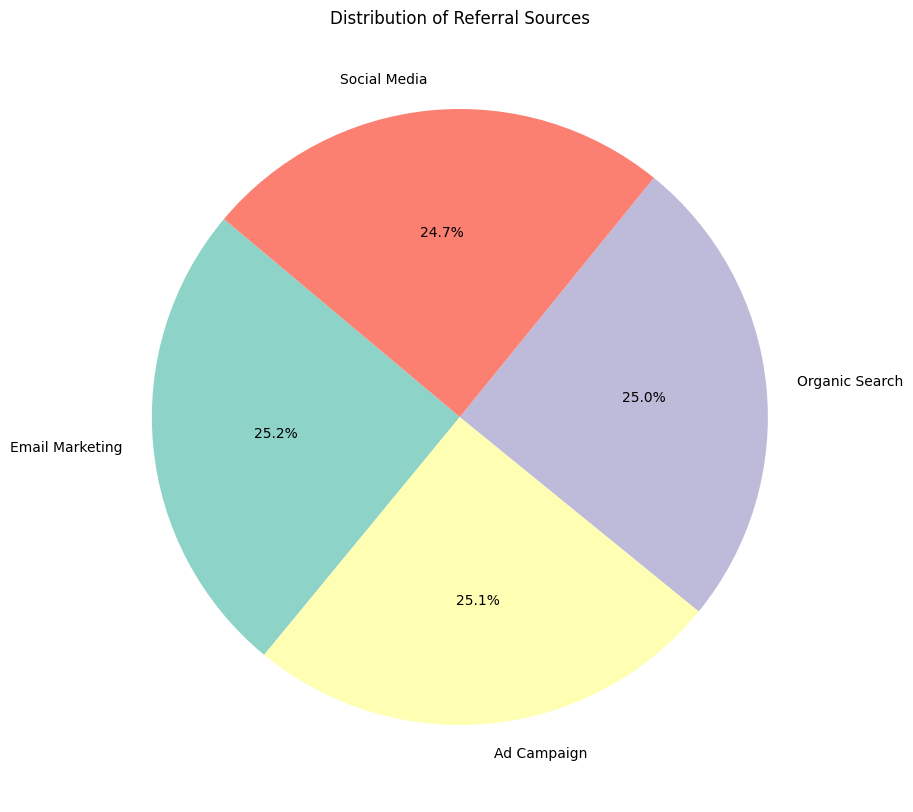

In [12]:
!pip install seaborn --quiet
import seaborn as sns
# Check for and remove any null values in the 'ReferralSource' column
referral_data = data['ReferralSource'].dropna()

# Count the distribution of 'ReferralSource'
referral_distribution = referral_data.value_counts()

# Plotting the distribution in a pie chart
plt.figure(figsize=(10, 10))
plt.pie(
    referral_distribution,
    labels=referral_distribution.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("Set3", len(referral_distribution))
)
plt.title('Distribution of Referral Sources')
plt.show()

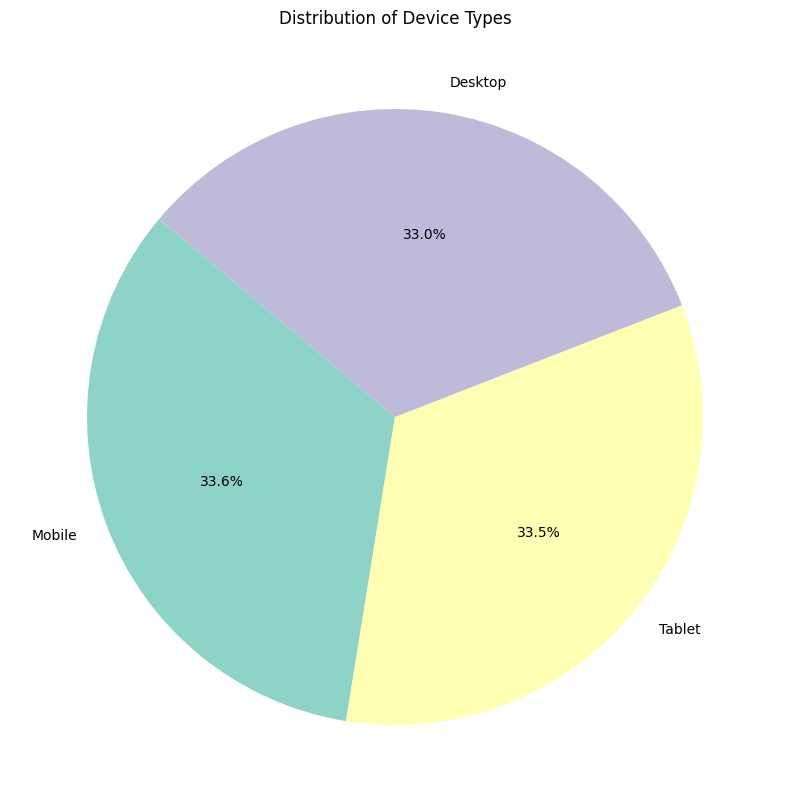

In [13]:
# Check for and remove any null values in the 'DeviceType' column
device_data = data['DeviceType'].dropna()

# Count the distribution of 'DeviceType'
device_distribution = device_data.value_counts()

# Plotting the distribution in a pie chart
plt.figure(figsize=(10, 10))
plt.pie(
    device_distribution,
    labels=device_distribution.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("Set3", len(device_distribution))
)
plt.title('Distribution of Device Types')
plt.show()

# Column to be Kept for Analysis

| Column(s)          | Description                                                   | Analysis                                                          |
|--------------------|---------------------------------------------------------------|-------------------------------------------------------------------|
| **ReviewScore**    | Numerical feedback that can be correlated with sentiment.     | Crucial for sentiment analysis and modeling.                      |
| **ReviewText**     | Main text data for NLP analysis.                              | Essential for NLP tasks such as sentiment classification.         |
| **ProductName, Category** | Could add context if needed.                           | Useful for contextualizing reviews and identifying product trends.|


# Step 2 - Drop columns that are not relevant for NLP and sentiment analysis

In [14]:
columns_to_drop = [
    'UserID', 'UserName', 'SignUpDate', 'LastLogin', 'SessionDuration',
    'Price', 'PurchaseDate', 'Quantity', 'TotalAmount',
    'HasDiscountApplied', 'DiscountRate', 'DeviceType', 'ReferralSource'
]

In [15]:
data_cleaned = data.drop(columns=columns_to_drop)

In [16]:
# Display the cleaned dataset structure
print("\nCleaned Dataset Preview:")
display(data_cleaned.head())


Cleaned Dataset Preview:


,Age,Gender,Country,ProductID,ProductName,Category,ReviewScore,ReviewText
0,39,Male,UK,8190,Shoes,Books,5.1,Excellent
1,25,Female,Canada,9527,T-shirt,Accessories,5.1,Excellent
2,43,Male,Canada,3299,Headphones,Apparel,3.2,Good
3,44,Male,Germany,8795,T-shirt,Apparel,4.3,Good
4,23,Female,Canada,1389,Shoes,Books,5.1,Average


In [17]:
# Check for any missing values
print("\nMissing Values in Each Column:")
missing_values = data_cleaned.isnull().sum()
display(missing_values)


Missing Values in Each Column:


,0
Age,0
Gender,0
Country,0
ProductID,0
ProductName,0
Category,0
ReviewScore,0
ReviewText,0


In [19]:
# Distribution of sentiments (ReviewScore)
print("\nDistribution of Review Scores:")
sentiment_distribution = data_cleaned['ReviewScore'].value_counts()
display(sentiment_distribution)


Distribution of Review Scores:


,count
ReviewScore,
4.0,4106
4.1,4032
3.9,4025
4.2,3984
3.8,3889
...,...
-0.5,1
8.1,1
8.6,1


# Step 2 - Convert the text to numerical features using TF-IDF.

In [20]:
# Preprocess text for modeling
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
X = tfidf.fit_transform(data_cleaned['ReviewText'].astype(str))
y = (data_cleaned['ReviewScore'] >= 4).astype(int)  # Binary classification: 1 for positive (4-5), 0 for negative (1-3)

# Step 3 - Split the dataset into training and testing sets.

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Step 4 - Apply the KNN algorithm.

In [23]:
# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)


KNeighborsClassifier()

In [24]:
# Make predictions and evaluate the model
y_pred = knn.predict(X_test)

In [25]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Negative', 'Positive'])

# Step 5 - Visualize the results with a confusion matrix and explain the positive/negative classification.

<Figure size 800x600 with 0 Axes>

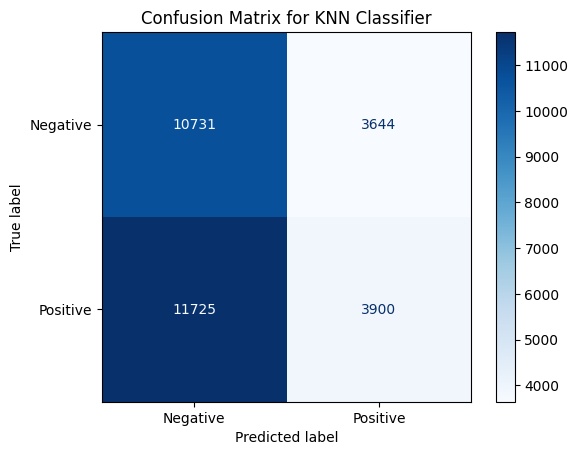

In [26]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for KNN Classifier")
plt.show()

In [27]:
# Display classification report
print("\nClassification Report:")
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print(report)


Classification Report:
              precision    recall  f1-score   support

    Negative       0.48      0.75      0.58     14375
    Positive       0.52      0.25      0.34     15625

    accuracy                           0.49     30000
   macro avg       0.50      0.50      0.46     30000
weighted avg       0.50      0.49      0.45     30000

